In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [5]:
!unzip "/content/drive/MyDrive/PA PER/data.zip"

Streaming output truncated to the last 5000 lines.
  inflating: data/954/20221114_12.jpg  
  inflating: data/954/20221114_14.jpg  
  inflating: data/954/20221114_16.jpg  
  inflating: data/954/2022-11-14_18.jpg  
  inflating: data/954/2022-11-14_2.jpg  
  inflating: data/954/20221114_20.jpg  
  inflating: data/954/20221114_22.jpg  
  inflating: data/954/20221114_24.jpg  
  inflating: data/954/2022-11-14_26.jpg  
  inflating: data/954/20221114_28.jpg  
  inflating: data/954/20221114_30.jpg  
  inflating: data/954/20221114_32.jpg  
  inflating: data/954/2022-11-14_34.jpg  
  inflating: data/954/20221114_36.jpg  
  inflating: data/954/20221114_38.jpg  
  inflating: data/954/20221114_4.jpg  
  inflating: data/954/20221114_40.jpg  
  inflating: data/954/2022-11-14_42.jpg  
  inflating: data/954/20221114_44.jpg  
  inflating: data/954/20221114_46.jpg  
  inflating: data/954/20221114_48.jpg  
  inflating: data/954/2022-11-14_50.jpg  
  inflating: data/954/20221114_52.jpg  
  inflating: data/9

In [6]:
data_dir = "/content/data"

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

In [7]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir, validation_split=0.2, subset="training", seed=123, image_size=IMG_SIZE, batch_size=BATCH_SIZE)

Found 442800 files belonging to 4428 classes.
Using 354240 files for training.


In [8]:
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir, validation_split=0.2, subset="validation", seed=123, image_size=IMG_SIZE, batch_size=BATCH_SIZE)

Found 442800 files belonging to 4428 classes.
Using 88560 files for validation.


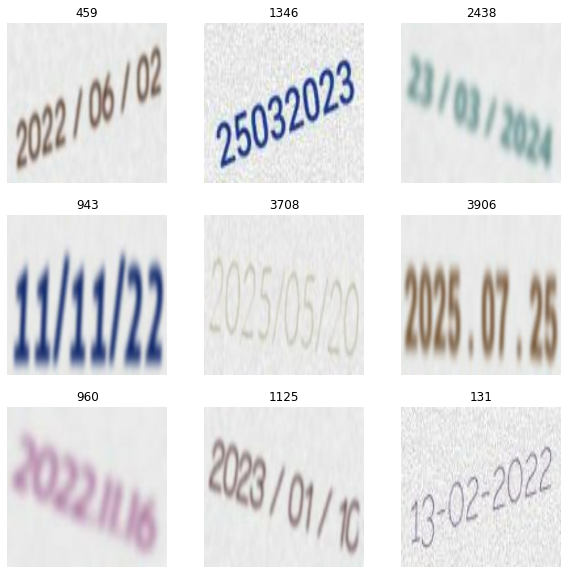

In [9]:
class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

karena dataset tidak memiliki data test, buat data test dari data validation dengan proporse 20%

In [10]:
val_batches = tf.data.experimental.cardinality(validation_ds)
test_ds = validation_ds.take(val_batches // 5)
validation_ds = validation_ds.skip(val_batches // 5)

In [11]:
print(f"Number of validation batches: {tf.data.experimental.cardinality(validation_ds)}")
print(f"Number of test batches: {tf.data.experimental.cardinality(test_ds)}")

Number of validation batches: 2215
Number of test batches: 553


#### Configure the dataset performance

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [13]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
])

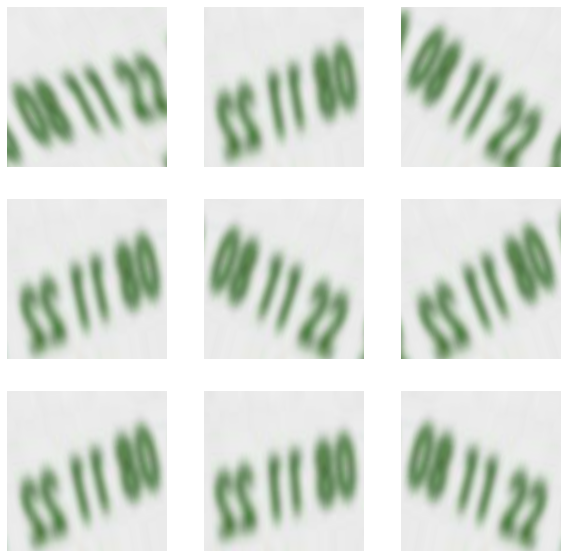

In [14]:
for image, _ in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

#### Rescale pixel values

menggunakan InceptionResnetV2 untuk base modelnya. Model ini mengarapkan nilai piksel antara -1 sampai 1. Untuk itu kita perlu melakukan rescale terhadap nilai pikselnya

In [15]:
preprocess_input = tf.keras.applications.inception_resnet_v2.preprocess_input

In [16]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

### Create the base model from the pre-trained convnets

In [17]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.InceptionResNetV2(input_shape=IMG_SHAPE, include_top=False, weights="imagenet")

219055592/219055592 [==============================] - 1s 0us/step


Fiture extractor ini mengkonversi setiap citra 160x160x3 menjadi 3x3x1536 blok fitur. kita akan menggunakan fitur ini untuk melakukan klasifikasi

In [18]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 3, 3, 1536)


### Feature extraction

##### Freeze the convolutional base

In [19]:
base_model.trainable = False

In [20]:
# Let's take a look at the base model architecture
# base_model.summary()

##### Add a classification head

In [21]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1536)


In [22]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [23]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

##### Compile the model

In [24]:
base_learning_rate = 0.0001
model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
)

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [25]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 inception_resnet_v2 (Functi  (None, 3, 3, 1536)       54336736  
 onal)                                                           
                                                             

In [26]:
len(model.trainable_variables)

2

##### Train the model

In [27]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_ds)

2215/2215 [==============================] - 247s 103ms/step - loss: 2201.8269 - accuracy: 1.6934e-04


In [28]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 2201.83
initial accuracy: 0.00


In [ ]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=validation_ds)

Epoch 1/10
11070/11070 [==============================] - 1692s 152ms/step - loss: -839819.5000 - accuracy: 2.4842e-04 - val_loss: -1497140.0000 - val_accuracy: 1.8345e-04
Epoch 2/10
11070/11070 [==============================] - 1684s 152ms/step - loss: -2524558.2500 - accuracy: 2.4560e-04 - val_loss: -2996298.5000 - val_accuracy: 1.8345e-04
Epoch 3/10
11070/11070 [==============================] - 1675s 151ms/step - loss: -4206906.0000 - accuracy: 2.4560e-04 - val_loss: -4495977.0000 - val_accuracy: 1.8345e-04
Epoch 4/10
11070/11070 [==============================] - 1698s 153ms/step - loss: -5894203.5000 - accuracy: 2.4560e-04 - val_loss: -5994167.5000 - val_accuracy: 1.8345e-04
Epoch 5/10
11070/11070 [==============================] - ETA: 0s - loss: -7572936.5000 - accuracy: 2.4560e-04

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()